# Q-Beat: Quantum Music Generation - Complete Testing
## Theory, Audio Synthesis, and Full Music Generation Pipeline

This notebook demonstrates the complete Q-Beat workflow:
1. Quantum circuit creation
2. Measurement outcome mapping
3. Audio synthesis from quantum states
4. Full music generation and playback

## Part 1: Install and Import Required Libraries

In [8]:
# Install required packages
import subprocess
import sys

packages = ['qiskit', 'qiskit-aer', 'numpy', 'scipy', 'matplotlib', 'pylatexenc']
for package in packages:
    try:
        __import__(package)
    except ImportError:
        print(f'Installing {package}...')
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

print('All packages installed!')

Installing qiskit-aer...
Installing pylatexenc...
Installing pylatexenc...
All packages installed!
All packages installed!


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from scipy.io import wavfile
import IPython.display as ipd

print('✓ All imports successful!')

✓ All imports successful!


## Part 2: Quantum Music Circuit Class

In [16]:
class QuantumMusicCircuit:
    """Quantum circuit that generates musical patterns."""
    
    def __init__(self, num_qubits=4, shots=1024):
        self.num_qubits = num_qubits
        self.shots = shots
        self.qr = QuantumRegister(num_qubits, 'q')
        self.cr = ClassicalRegister(num_qubits, 'c')
        self.circuit = QuantumCircuit(self.qr, self.cr)
        self.simulator = AerSimulator()
        print(f'✓ Created quantum circuit: {num_qubits} qubits')
    
    def add_superposition(self, qubit):
        """Add Hadamard gate for superposition."""
        self.circuit.h(qubit)
    
    def add_rotation(self, qubit, angle, axis='y'):
        """Add rotation gate."""
        if axis == 'x':
            self.circuit.rx(angle, qubit)
        elif axis == 'y':
            self.circuit.ry(angle, qubit)
        elif axis == 'z':
            self.circuit.rz(angle, qubit)
    
    def add_entanglement(self, control, target):
        """Entangle qubits using CNOT."""
        self.circuit.cx(control, target)
    
    def add_phase_gate(self, qubit, phase):
        """Add phase gate for timbre control."""
        self.circuit.p(phase, qubit)
    
    def measure_all(self):
        """Measure all qubits."""
        self.circuit.measure(self.qr, self.cr)
    
    def execute(self):
        """Execute circuit and get measurement results."""
        # Create copy to avoid re-measuring
        circ = self.circuit.copy()
        if not any(instr.operation.name == 'measure' for instr in circ.data):
            circ.measure(self.qr, self.cr)
        
        job = self.simulator.run(circ, shots=self.shots)
        result = job.result()
        counts = result.get_counts()
        return counts
    
    def get_qubit_probabilities(self):
        """Get probability of each qubit being |1>."""
        counts = self.execute()
        total = sum(counts.values())
        qubit_probs = [0.0] * self.num_qubits
        
        for bitstring, count in counts.items():
            for i, bit in enumerate(reversed(bitstring)):
                if bit == '1':
                    qubit_probs[i] += count / total
        
        return qubit_probs
    
    def get_statevector(self):
        """Get statevector without measurement."""
        from qiskit.quantum_info import Statevector
        circ = self.circuit.copy()
        # Remove measurements if any
        circ = circ.remove_final_measurements(inplace=False)
        statevector = Statevector.from_instruction(circ)
        return statevector.data
    
    def get_amplitudes(self):
        """Get amplitude vector for volume mapping."""
        statevector = self.get_statevector()
        amplitudes = np.abs(statevector)
        return amplitudes
    
    def get_phases(self):
        """Get phase vector for timbre mapping."""
        statevector = self.get_statevector()
        phases = np.angle(statevector)
        return phases
    
    def visualize_circuit(self):
        """Display circuit diagram."""
        return self.circuit.draw('mpl')

print('✓ QuantumMusicCircuit class defined')

✓ QuantumMusicCircuit class defined


## Part 3: Audio Synthesizer Class

In [11]:
class AudioSynthesizer:
    """Converts quantum states to audio."""
    
    def __init__(self, sample_rate=44100, channels=2):
        self.sample_rate = sample_rate
        self.channels = channels
        print(f'✓ Audio synthesizer: {sample_rate}Hz, {channels} channels')
    
    @staticmethod
    def midi_to_frequency(midi_note):
        """Convert MIDI note to frequency."""
        return 440.0 * (2.0 ** ((midi_note - 69) / 12.0))
    
    def generate_sine_wave(self, frequency, duration, amplitude=0.5, phase=0.0):
        """Generate sine wave."""
        num_samples = int(duration * self.sample_rate)
        t = np.linspace(0, duration, num_samples, False)
        wave = amplitude * np.sin(2 * np.pi * frequency * t + phase)
        return wave
    
    def generate_note(self, midi_note, duration=0.25, amplitude=0.5, phase=0.0):
        """Generate musical note from MIDI number."""
        frequency = self.midi_to_frequency(midi_note)
        return self.generate_sine_wave(frequency, duration, amplitude, phase)
    
    def add_adsr_envelope(self, wave, attack=0.01, decay=0.1, sustain=0.7, release=0.2):
        """Apply ADSR envelope to waveform."""
        num_samples = len(wave)
        envelope = np.ones(num_samples)
        
        attack_samples = int(attack * self.sample_rate)
        decay_samples = int(decay * self.sample_rate)
        release_samples = int(release * self.sample_rate)
        sustain_start = attack_samples + decay_samples
        sustain_end = num_samples - release_samples
        
        if attack_samples > 0:
            envelope[:attack_samples] = np.linspace(0, 1, attack_samples)
        if decay_samples > 0:
            envelope[attack_samples:sustain_start] = np.linspace(1, sustain, decay_samples)
        envelope[sustain_start:sustain_end] = sustain
        if release_samples > 0:
            envelope[-release_samples:] = np.linspace(sustain, 0, release_samples)
        
        return wave * envelope
    
    def generate_drum_sound(self, drum_type, duration=0.25):
        """Generate synthetic drum sounds."""
        num_samples = int(duration * self.sample_rate)
        t = np.linspace(0, duration, num_samples)
        
        if drum_type == 'kick':
            # Kick: pitch decay
            freq_envelope = 150 * np.exp(-10 * t) + 50
            phase_val = 2 * np.pi * np.cumsum(freq_envelope) / self.sample_rate
            wave = np.sin(phase_val)
            envelope = np.exp(-5 * t)
            return wave * envelope
        
        elif drum_type == 'snare':
            # Snare: noise + tone
            noise = np.random.normal(0, 0.3, num_samples)
            sine = 0.3 * np.sin(2 * np.pi * 200 * t)
            wave = noise + sine
            envelope = np.exp(-8 * t)
            return wave * envelope
        
        elif drum_type == 'hihat':
            # Hi-hat: filtered noise
            noise = np.random.normal(0, 0.2, num_samples)
            envelope = np.exp(-15 * t)
            return noise * envelope
        
        else:
            return np.zeros(num_samples)
    
    def quantum_to_audio(self, qubit_probs, note_map, duration=0.25, phases=None):
        """Convert quantum probabilities to audio.
        
        Args:
            qubit_probs: Probability of each qubit being |1>
            note_map: Mapping qubit index -> MIDI note
            duration: Note duration in seconds
            phases: Phase information for timbre
        
        Returns:
            Combined audio waveform
        """
        num_samples = int(duration * self.sample_rate)
        combined_wave = np.zeros(num_samples)
        
        for i, prob in enumerate(qubit_probs):
            if prob > 0.1:  # Threshold
                midi_note = note_map.get(i, 60)
                phase = phases[i] if phases is not None else 0.0
                
                # Amplitude from probability
                amplitude = np.sqrt(prob) * 0.3  # Scale down
                
                wave = self.generate_note(midi_note, duration, amplitude, phase)
                wave = self.add_adsr_envelope(wave)
                combined_wave += wave
        
        # Normalize
        if np.max(np.abs(combined_wave)) > 0:
            combined_wave /= np.max(np.abs(combined_wave)) * 1.1
        
        return combined_wave
    
    def save_wav(self, waveform, filename, volume=0.9):
        """Save waveform as WAV file."""
        # Normalize and convert to 16-bit
        waveform = np.clip(waveform * volume, -1, 1)
        waveform_int16 = (waveform * 32767).astype(np.int16)
        
        # Save
        wavfile.write(filename, self.sample_rate, waveform_int16)
        print(f'✓ Saved: {filename}')
    
    def play_audio(self, waveform):
        """Play audio in Jupyter notebook."""
        # Normalize
        waveform = np.clip(waveform, -1, 1)
        return ipd.Audio(waveform, rate=self.sample_rate)

print('✓ AudioSynthesizer class defined')

✓ AudioSynthesizer class defined


## Part 4: Test Example 1 - Basic Drum Pattern

In [17]:
print('\n' + '='*60)
print('EXAMPLE 1: Basic Drum Pattern - Kick + Snare')
print('='*60)

# Create 4-qubit circuit
qc = QuantumMusicCircuit(num_qubits=4, shots=1024)

# Qubit 0: Kick drum
qc.add_superposition(0)
qc.add_rotation(0, np.pi/4, 'y')

# Qubit 1: Snare (entangled with kick)
qc.add_entanglement(0, 1)
qc.add_rotation(1, np.pi/6, 'x')

# Qubit 2: Hi-hat
qc.add_superposition(2)
qc.add_phase_gate(2, np.pi/2)

# Qubit 3: Open hi-hat (high frequency)
qc.add_superposition(3)
qc.add_rotation(3, np.pi/3, 'z')

print('\nCircuit created!')
print(f'Circuit depth: {qc.circuit.depth()}')


EXAMPLE 1: Basic Drum Pattern - Kick + Snare
✓ Created quantum circuit: 4 qubits

Circuit created!
Circuit depth: 4



Quantum Circuit Diagram:
     ┌───┐┌─────────┐                
q_0: ┤ H ├┤ Ry(π/4) ├──■─────────────
     └───┘└─────────┘┌─┴─┐┌─────────┐
q_1: ────────────────┤ X ├┤ Rx(π/6) ├
     ┌───┐ ┌────────┐└───┘└─────────┘
q_2: ┤ H ├─┤ P(π/2) ├────────────────
     ├───┤┌┴────────┤                
q_3: ┤ H ├┤ Rz(π/3) ├────────────────
     └───┘└─────────┘                
c: 4/════════════════════════════════
                                     


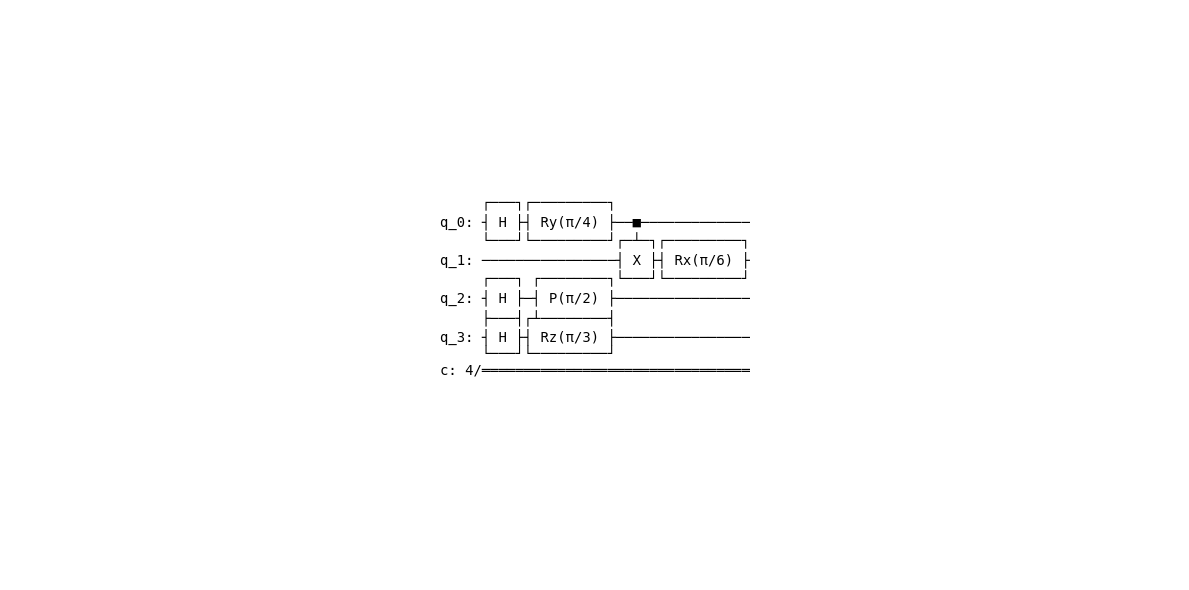

In [19]:
# Visualize circuit (using text format instead of matplotlib)
print('\nQuantum Circuit Diagram:')
print(qc.circuit.draw('text'))
plt.figure(figsize=(12, 6))
plt.text(0.5, 0.5, str(qc.circuit.draw('text')), 
         fontfamily='monospace', fontsize=10, ha='center', va='center')
plt.axis('off')
plt.tight_layout()
plt.show()


Measurement Outcomes:
  1011: 213 times (20.8%)
  0011: 208 times (20.3%)
  0111: 199 times (19.4%)
  1111: 196 times (19.1%)
  0000: 40 times (3.9%)


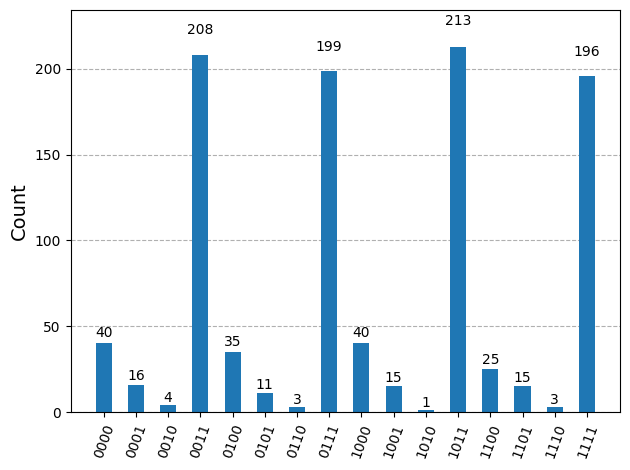

In [20]:
# Get measurement outcomes
counts = qc.execute()
print('\nMeasurement Outcomes:')
for state, count in sorted(counts.items(), key=lambda x: x[1], reverse=True)[:5]:
    print(f'  {state}: {count} times ({count/10.24:.1f}%)')

# Visualize histogram
plot_histogram(counts)


Qubit Probabilities (P(|1>)):
  Qubit 0 (Kick):     0.845
  Qubit 1 (Snare):    0.807
  Qubit 2 (HiHat):    0.508
  Qubit 3 (OpenHat):  0.515


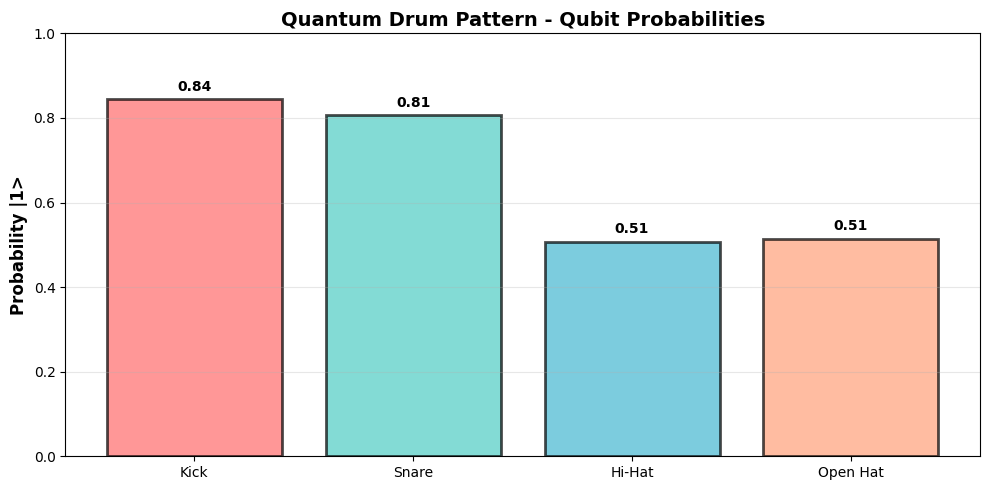

In [21]:
# Get probabilities
probs = qc.get_qubit_probabilities()
print('\nQubit Probabilities (P(|1>)):')
print(f'  Qubit 0 (Kick):     {probs[0]:.3f}')
print(f'  Qubit 1 (Snare):    {probs[1]:.3f}')
print(f'  Qubit 2 (HiHat):    {probs[2]:.3f}')
print(f'  Qubit 3 (OpenHat):  {probs[3]:.3f}')

# Visualize probabilities
fig, ax = plt.subplots(figsize=(10, 5))
instruments = ['Kick', 'Snare', 'Hi-Hat', 'Open Hat']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
ax.bar(instruments, probs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Probability |1>', fontsize=12, fontweight='bold')
ax.set_title('Quantum Drum Pattern - Qubit Probabilities', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
for i, p in enumerate(probs):
    ax.text(i, p + 0.02, f'{p:.2f}', ha='center', fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Part 5: Generate Audio from Quantum Circuit

In [22]:
print('\n' + '='*60)
print('Generating Audio from Quantum States')
print('='*60)

# Initialize synthesizer
synth = AudioSynthesizer(sample_rate=44100)

# Map qubits to drum sounds
note_map = {
    0: 36,   # Kick (C2)
    1: 38,   # Snare (D2)
    2: 42,   # Closed Hi-Hat (F#2)
    3: 46    # Open Hi-Hat (A#2)
}

print('\nNote Mapping:')
print('  Qubit 0 -> MIDI 36 (Kick)')
print('  Qubit 1 -> MIDI 38 (Snare)')
print('  Qubit 2 -> MIDI 42 (Closed Hi-Hat)')
print('  Qubit 3 -> MIDI 46 (Open Hi-Hat)')


Generating Audio from Quantum States
✓ Audio synthesizer: 44100Hz, 2 channels

Note Mapping:
  Qubit 0 -> MIDI 36 (Kick)
  Qubit 1 -> MIDI 38 (Snare)
  Qubit 2 -> MIDI 42 (Closed Hi-Hat)
  Qubit 3 -> MIDI 46 (Open Hi-Hat)


In [23]:
# Generate audio for one beat
probs = qc.get_qubit_probabilities()
phases = qc.get_phases()[:len(probs)]  # For timbre

beat_duration = 0.5  # 500ms per beat
audio_beat = synth.quantum_to_audio(probs, note_map, duration=beat_duration, phases=phases)

print(f'\n✓ Generated beat: {beat_duration}s duration')
print(f'  Audio shape: {audio_beat.shape}')
print(f'  Peak amplitude: {np.max(np.abs(audio_beat)):.3f}')


✓ Generated beat: 0.5s duration
  Audio shape: (22050,)
  Peak amplitude: 0.909


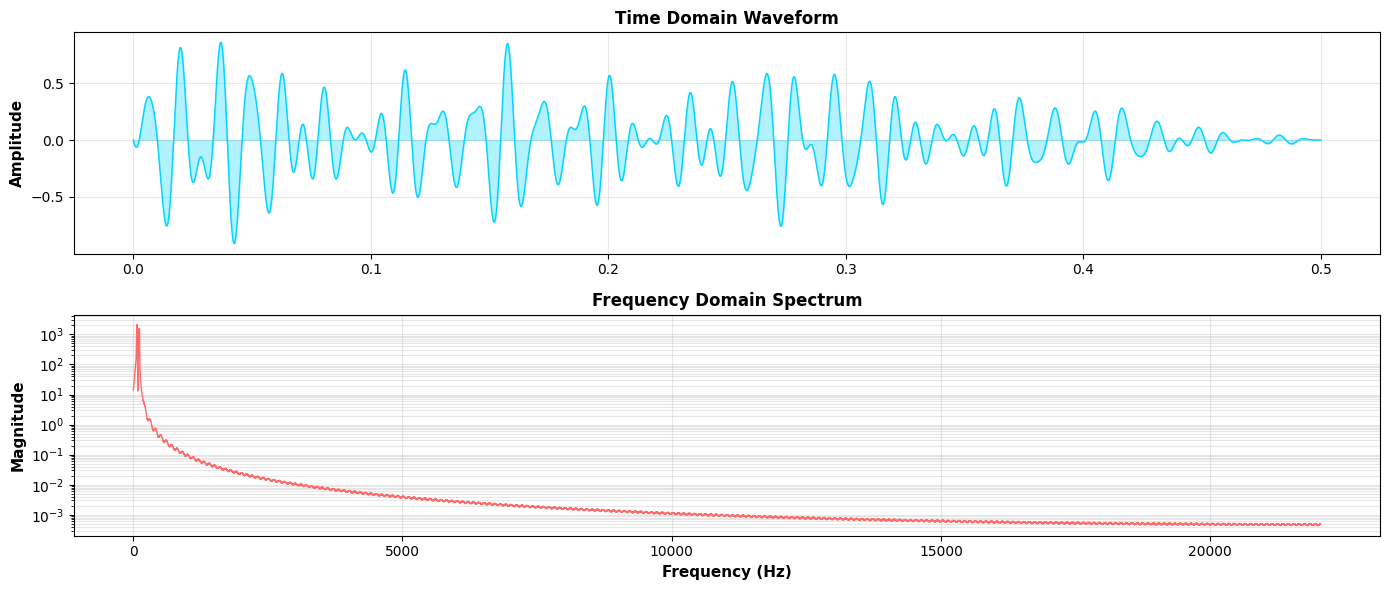

In [24]:
# Visualize waveform
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

# Time domain
time = np.linspace(0, beat_duration, len(audio_beat))
axes[0].plot(time, audio_beat, linewidth=1, color='#00D4FF')
axes[0].fill_between(time, audio_beat, alpha=0.3, color='#00D4FF')
axes[0].set_ylabel('Amplitude', fontsize=11, fontweight='bold')
axes[0].set_title('Time Domain Waveform', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Frequency domain
fft = np.abs(np.fft.fft(audio_beat))
freqs = np.fft.fftfreq(len(audio_beat), 1/44100)
axes[1].semilogy(freqs[:len(freqs)//2], fft[:len(fft)//2], linewidth=1, color='#FF6B6B')
axes[1].set_xlabel('Frequency (Hz)', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Magnitude', fontsize=11, fontweight='bold')
axes[1].set_title('Frequency Domain Spectrum', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

In [25]:
# Play audio
print('\n▶️  Playing generated beat:')
ipd.display(synth.play_audio(audio_beat))


▶️  Playing generated beat:


## Part 6: Generate Multi-Beat Sequence

In [26]:
print('\n' + '='*60)
print('Generating 4-Beat Drum Sequence')
print('='*60)

# Create 4-beat sequence
num_beats = 4
bpm = 120
beat_duration = 60.0 / bpm  # Quarter note duration

sequence = np.array([])

print(f'\nParameters:')
print(f'  BPM: {bpm}')
print(f'  Beat duration: {beat_duration:.3f}s')
print(f'  Number of beats: {num_beats}')

for beat_num in range(num_beats):
    # Create new circuit for each beat (variation)
    qc_beat = QuantumMusicCircuit(num_qubits=4, shots=512)
    
    # Vary pattern per beat
    qc_beat.add_superposition(0)
    qc_beat.add_rotation(0, np.pi/4 * (beat_num + 1), 'y')
    
    qc_beat.add_entanglement(0, 1)
    qc_beat.add_rotation(1, np.pi/6 * beat_num, 'x')
    
    qc_beat.add_superposition(2)
    qc_beat.add_phase_gate(2, np.pi/2 * (beat_num % 2))
    
    qc_beat.add_superposition(3)
    
    # Generate audio
    probs = qc_beat.get_qubit_probabilities()
    phases = qc_beat.get_phases()[:len(probs)]
    beat_audio = synth.quantum_to_audio(probs, note_map, duration=beat_duration, phases=phases)
    
    sequence = np.concatenate([sequence, beat_audio])
    print(f'  Beat {beat_num + 1} generated')

print(f'\n✓ Sequence generated: {len(sequence)/44100:.3f}s total')


Generating 4-Beat Drum Sequence

Parameters:
  BPM: 120
  Beat duration: 0.500s
  Number of beats: 4
✓ Created quantum circuit: 4 qubits
  Beat 1 generated
✓ Created quantum circuit: 4 qubits
  Beat 2 generated
✓ Created quantum circuit: 4 qubits
  Beat 3 generated
✓ Created quantum circuit: 4 qubits
  Beat 4 generated

✓ Sequence generated: 2.000s total


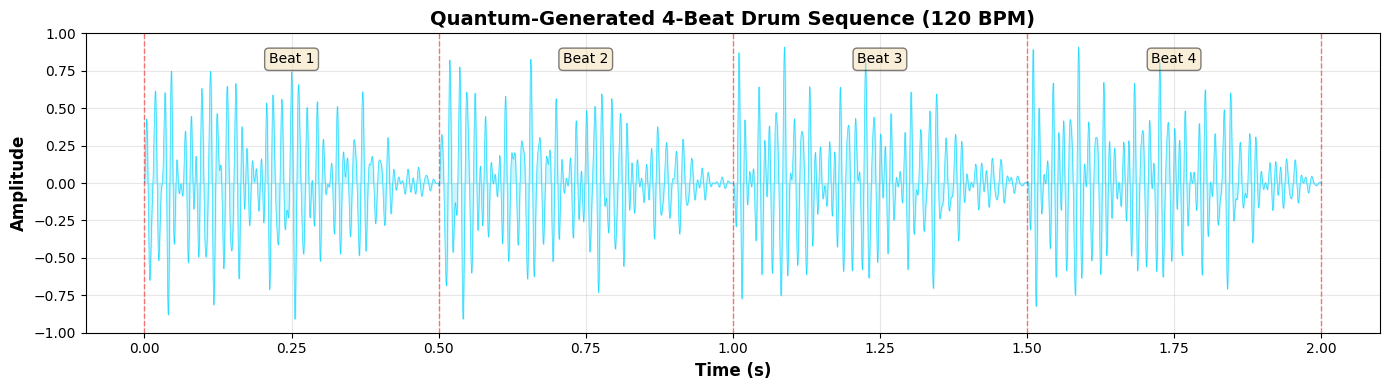

In [27]:
# Visualize full sequence
fig, ax = plt.subplots(figsize=(14, 4))

time = np.linspace(0, len(sequence)/44100, len(sequence))
ax.plot(time, sequence, linewidth=0.5, color='#00D4FF', alpha=0.8)
ax.fill_between(time, sequence, alpha=0.2, color='#00D4FF')

# Mark beat boundaries
for beat in range(num_beats + 1):
    beat_time = beat * beat_duration
    ax.axvline(beat_time, color='red', linestyle='--', alpha=0.5, linewidth=1)
    if beat < num_beats:
        ax.text(beat_time + beat_duration/2, 0.8, f'Beat {beat+1}', 
               ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

ax.set_xlabel('Time (s)', fontsize=12, fontweight='bold')
ax.set_ylabel('Amplitude', fontsize=12, fontweight='bold')
ax.set_title(f'Quantum-Generated {num_beats}-Beat Drum Sequence ({bpm} BPM)', fontsize=14, fontweight='bold')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [28]:
# Play full sequence
print('\n▶️  Playing 4-beat quantum drum sequence:')
ipd.display(synth.play_audio(sequence))


▶️  Playing 4-beat quantum drum sequence:


In [29]:
# Save to file
synth.save_wav(sequence, 'quantum_drum_sequence.wav', volume=0.9)
print('File saved! You can download it.')

✓ Saved: quantum_drum_sequence.wav
File saved! You can download it.


## Part 7: Advanced Example - Polyrhythm using Superposition

In [30]:
print('\n' + '='*60)
print('Example 2: Polyrhythmic Pattern - Complex Superposition')
print('='*60)

qc_poly = QuantumMusicCircuit(num_qubits=4, shots=1024)

# Create complex superposition for polyrhythm
for i in range(4):
    qc_poly.add_superposition(i)  # Equal superposition
    qc_poly.add_rotation(i, np.pi * (i + 1) / 4, 'y')  # Different rotations

# Create some entanglement for correlation
qc_poly.add_entanglement(0, 2)
qc_poly.add_entanglement(1, 3)

print('\nPolyrhythmic circuit created')
print(f'Circuit depth: {qc_poly.circuit.depth()}')


Example 2: Polyrhythmic Pattern - Complex Superposition
✓ Created quantum circuit: 4 qubits

Polyrhythmic circuit created
Circuit depth: 3


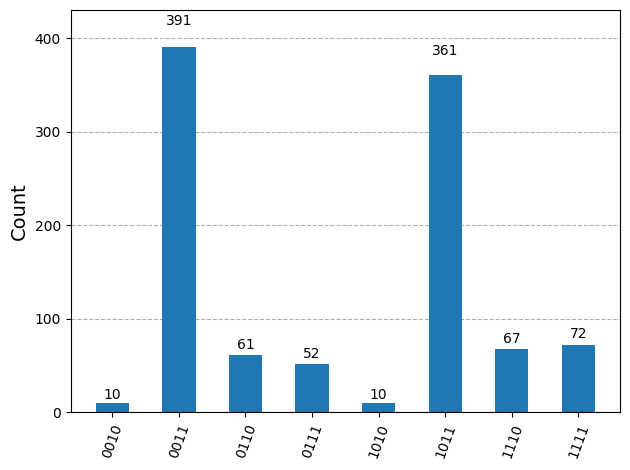

In [31]:
# Measure and visualize
counts_poly = qc_poly.execute()
plot_histogram(counts_poly)

In [32]:
# Generate polyrhythmic audio (8 beats)
poly_sequence = np.array([])
beat_duration_poly = 0.375  # Triplet feel

for beat in range(8):
    probs = qc_poly.get_qubit_probabilities()
    # Slightly rotate for variation each beat
    if beat % 2 == 0:
        phases = qc_poly.get_phases()[:len(probs)] * (beat / 8)
    else:
        phases = qc_poly.get_phases()[:len(probs)] * (1 - beat / 8)
    
    beat_audio = synth.quantum_to_audio(probs, note_map, duration=beat_duration_poly, phases=phases)
    poly_sequence = np.concatenate([poly_sequence, beat_audio])

print('✓ Polyrhythmic sequence generated (8 beats)')

✓ Polyrhythmic sequence generated (8 beats)


In [33]:
# Play polyrhythm
print('\n▶️  Playing polyrhythmic quantum music:')
ipd.display(synth.play_audio(poly_sequence))
synth.save_wav(poly_sequence, 'quantum_polyrhythm.wav', volume=0.9)


▶️  Playing polyrhythmic quantum music:


✓ Saved: quantum_polyrhythm.wav


## Part 8: Quantum Concepts Analysis

In [34]:
print('\n' + '='*60)
print('Quantum Concepts in Q-Beat')
print('='*60)

print('''\n1. SUPERPOSITION
   - Hadamard gates create equal |0> and |1> states
   - Each qubit can represent multiple drum sounds simultaneously
   - Creates probability distributions for rhythm patterns

2. ENTANGLEMENT
   - CNOT gates link qubits (e.g., kick with snare)
   - Correlated measurement outcomes
   - Creates musically related patterns

3. AMPLITUDE (Volume)
   - |ψ|² probability maps to sound volume
   - Higher probability = louder note
   - Creates dynamic range variations

4. PHASE (Timbre)
   - Quantum phase affects harmonic content
   - Phase gates modify sound color
   - Controls interference patterns in audio

5. MEASUREMENT
   - Collapsing superposition chooses specific rhythm
   - Statistical distribution creates pattern
   - 1024 shots = 1024 possible rhythm variations
''')


Quantum Concepts in Q-Beat

1. SUPERPOSITION
   - Hadamard gates create equal |0> and |1> states
   - Each qubit can represent multiple drum sounds simultaneously
   - Creates probability distributions for rhythm patterns

2. ENTANGLEMENT
   - CNOT gates link qubits (e.g., kick with snare)
   - Correlated measurement outcomes
   - Creates musically related patterns

3. AMPLITUDE (Volume)
   - |ψ|² probability maps to sound volume
   - Higher probability = louder note
   - Creates dynamic range variations

4. PHASE (Timbre)
   - Quantum phase affects harmonic content
   - Phase gates modify sound color
   - Controls interference patterns in audio

5. MEASUREMENT
   - Collapsing superposition chooses specific rhythm
   - Statistical distribution creates pattern
   - 1024 shots = 1024 possible rhythm variations



## Part 9: Summary & Mapping Reference

In [35]:
print('\n' + '='*60)
print('Q-BEAT: Quantum to Music Mapping')
print('='*60)

mapping = {
    'Quantum Component': ['Probability P(|1>)', 'Phase angle', 'Entanglement', 'Superposition', 'Circuit depth'],
    'Music Feature': ['Note volume', 'Timbre/harmonics', 'Chord/rhythm sync', 'Polyrhythm', 'Sequence length'],
    'Audio Parameter': ['Amplitude', 'Frequency mix', 'Correlation', 'Multiple notes', 'Total duration']
}

print('\n{:<30} {:<30} {:<20}'.format('QUANTUM', 'MUSIC', 'AUDIO'))
print('-' * 80)
for i in range(len(mapping['Quantum Component'])):
    print('{:<30} {:<30} {:<20}'.format(
        mapping['Quantum Component'][i],
        mapping['Music Feature'][i],
        mapping['Audio Parameter'][i]
    ))

print('\n' + '='*60)
print('✓ All music generation tests complete!')
print('='*60)


Q-BEAT: Quantum to Music Mapping

QUANTUM                        MUSIC                          AUDIO               
--------------------------------------------------------------------------------
Probability P(|1>)             Note volume                    Amplitude           
Phase angle                    Timbre/harmonics               Frequency mix       
Entanglement                   Chord/rhythm sync              Correlation         
Superposition                  Polyrhythm                     Multiple notes      
Circuit depth                  Sequence length                Total duration      

✓ All music generation tests complete!
